In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import pandas as pd
import numpy as np
import datetime
from scipy.io.arff import loadarff
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import math
import plotly.graph_objects as go
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import tree
from imblearn.combine import SMOTETomek
import pydotplus
from scipy.io import arff
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import sys

In [ ]:
def removeOutliers(data, col, original):
	Q3 = np.quantile(data[col], 0.75)
	Q1 = np.quantile(data[col], 0.25)
	IQR = Q3 - Q1
	# print("IQR value for column %s is: %s" % (col, IQR))
	global outlier_free_list
	global outlier_list
	global outlier_inst
	global filtered_data
	global classify_df
	lower_range = Q1 - 1.5 * IQR
	upper_range = Q3 + 1.5 * IQR
	classify_df = original.copy()
	classify_df['outlier'] = 0
	for i in range(data.shape[0]):
		if data['score'][i] <= lower_range or data['score'][i] >= upper_range:
			classify_df['outlier'][i] = 1
	outlier_free_list = [x for x in data[col] if (
		(x > lower_range) & (x < upper_range))]
	outlier_list = [x for x in data[col] if (
		(x <= lower_range) | (x >= upper_range))]
	filtered_data = original.loc[data[col].isin(outlier_free_list)]
	outlier_inst = original.loc[data[col].isin(outlier_list)]

In [ ]:
def MapFunc(df, str_ar):
  for i in range(len(str_ar)):
    uni = df[str_ar[i]].unique()
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
  return df

In [ ]:
def temporal_distance(df, target, X_test, pred):
  td = 0
  ttc = 0
  ctt = 0
  C0 = X_test[target == 1]
  C1 = X_test[ pred == 1]
  ind_C0 = C0.index
  ind_C1 = C1.index
  #target to candidate
  for i in ind_C0:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    for j in ind_C1:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds() / 60
      min_d = min(minutes, min_d)
    ttc = ttc + min_d

  #candidate to target
  for i in ind_C1:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    for j in ind_C0:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds()/60
      min_d = min(minutes, min_d)
    ctt = ctt + min_d

  td = ttc + ctt
  return td

In [ ]:
def squared_temporal_distance(df, target, X_test, pred):
  td = 0
  ttc = 0
  ctt = 0
  C0 = X_test[target == 1]
  C1 = X_test[ pred == 1]
  ind_C0 = C0.index
  ind_C1 = C1.index
  #target to candidate
  for i in ind_C0:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    for j in ind_C1:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds() / 60
      min_d = min(minutes, min_d)
    ttc = ttc + (min_d)**2

  #candidate to target
  for i in ind_C1:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    for j in ind_C0:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds()/60
      min_d = min(minutes, min_d)
    ctt = ctt + (min_d)**2

  td = ttc + ctt
  return td

In [ ]:
def weighted_sum(df, target, X_test, pred):
  ws = 0
  C0 = X_test[target == 1]
  C1 = X_test[ pred == 1]
  ind_C0 = C0.index
  ind_C1 = C1.index
  #target to candidate
  w = []
  for i in ind_C0:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    max_d = float('-inf')
    for j in ind_C1:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds() / 60
      min_d = min(minutes, min_d)
    w.append(min_d)
  # print(max_d)

  for i in w:
    ws = ws + (1 - (i/max(w)) )
  return ws

In [ ]:
def weighted_detection_difference(df, target, X_test, pred):
  wwd = 0
  fa_count = 0
  fa_index = []
  C0 = X_test[target == 1]
  C1 = X_test[pred == 1]
  ind_C0 = C0.index
  ind_C1 = C1.index

  for i in ind_C1:
    if i in ind_C0:
      continue
    else:
      fa_index.append(i)
      fa_count = fa_count + 1

  ws = weighted_sum(df, target, X_test, pred)

  wf_array = []

  for i in fa_index:
    a = datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
    min_d = float('inf')
    for j in ind_C0:
      b = datetime.strptime(df['date'][j], '%Y-%m-%d %H:%M:%S')
      if a>b:
        c = a-b
      else :
        c = b-a
      minutes = c.total_seconds() / 60
      min_d = min(minutes, min_d)
    wf_array.append(min_d)

  if len(wf_array) == 0:
    wf_avg = 0
  else:
    wf_avg = sum(wf_array) #/len(wf_array)
  # print(fa_count)
  wwd = ws - wf_avg*fa_count
  return wwd, fa_index

Removing Outliers
----------------------

Occupancy Dataset
------------------------------
https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [ ]:
df = pd.read_csv('drive/MyDrive/Datasets/occupancy_train.txt')
df.reset_index(drop=True, inplace=True)
print(df.head())
df.info()

                  date  Temperature  Humidity  Light     CO2  HumidityRatio  \
0  2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
1  2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
2  2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
3  2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
4  2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
0          1  
1          1  
2          1  
3          1  
4          1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8

In [ ]:
del df['date']
df = df.astype(float)
std_dev=df.std()
avg=df.mean()
str_ar = ['Occupancy']
for i in str_ar:
    std_dev[i]=1
    avg[i]=0
df= (df- avg)/std_dev
df['score']=df.sum(axis=1)

In [ ]:
original = pd.read_csv('drive/MyDrive/Datasets/occupancy_train.txt')
original.reset_index(drop=True, inplace=True)
original.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
for s in df.columns:
  temp = df[s].copy()
  median = temp.median()
  df[s] = df[s].replace('nan',median)

In [ ]:
removeOutliers(df, 'score' ,original)
data = filtered_data
print("Shape of data after outlier removal is: ", data.shape)
print(df.shape)
# outlier_inst = outlier_inst.drop['target',1]
print(outlier_inst)

-2.288739543023646
1.8630486778869688
4.151788220910615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Shape of data after outlier removal is:  (7730, 7)
(8143, 7)
                     date  Temperature   Humidity   Light          CO2  \
1106  2015-02-05 12:16:59    22.390000  26.790000  696.50  1078.000000   
1108  2015-02-05 12:19:00    22.426667  27.000000  744.00  1098.333333   
1109  2015-02-05 12:20:00    22.472500  26.890000  708.75  1099.000000   
1111  2015-02-05 12:22:00    22.575000  26.840000  660.00  1093.500000   
1112  2015-02-05 12:23:00    22.600000  26.790000  688.50  1100.500000   
...                   ...          ...        ...     ...          ...   
7228  2015-02-09 18:19:00    21.790000  37.200000    0.00  1660.500000   
7229  2015-02-09 18:20:00    21.790000  37.200000    0.00  1640.500000   
7230  2015-02-09 18:21:00    21.730000  37.126667    0.00  1629.000000   
7231  2015-02-09 18:22:00    21.745000  37.145000    0.00  1627.000000   
7232  2015-02-09 18:23:00    21.700000  37.145000    0.00  1623.500000   

      HumidityRatio  Occupancy  
1106       0.0044

In [ ]:
data.to_csv('drive/MyDrive/Modified_Datasets/IQRAfterRemovingOutliers/occupancy.csv', index = False)

In [ ]:
classify_df = classify_df.drop('Occupancy',1)
classify_df.to_csv('drive/MyDrive/Modified_Datasets/IQROutlier_Classification/occupancy.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Sensor Dataset
-----------------

In [ ]:
df = pd.read_csv('drive/MyDrive/Datasets/sensor.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [ ]:
# Drop duplicates
df = df.drop_duplicates()
# Entire "sensor_15" column is NaN therefore remove it from data
del df['sensor_15']
# Let's convert the data type of timestamp column to datatime format
warnings.filterwarnings("ignore")
df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']
df

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,date
0,0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:00:00
1,1,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:01:00
2,2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,2018-04-01 00:02:00
3,3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,2018-04-01 00:03:00
4,4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL,2018-08-31 23:55:00
220316,220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL,2018-08-31 23:56:00
220317,220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL,2018-08-31 23:57:00
220318,220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL,2018-08-31 23:58:00


In [ ]:
# Extract the readings from the BROKEN state of the pump
broken = df[df['machine_status']=='BROKEN']
# Extract the names of the numerical columns
df2 = df.drop(['machine_status'], axis=1)
names=df2.columns
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

In [ ]:
# # Resample the entire dataset by daily average
# rollmean = df.resample(rule='D').mean()
# rollstd = df.resample(rule='D').std()
# # Plot time series for each sensor with its mean and standard deviation
# for name in names:
#     _ = plt.figure(figsize=(18,3))
#     _ = plt.plot(df[name], color='blue', label='Original')
#     _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
#     _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
#     _ = plt.legend(loc='best')
#     _ = plt.title(name)
#     plt.show()

In [ ]:
cols = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51']
val = df['sensor_50'][220319]
for s in cols:
  temp = df[s].copy()
  temp = temp.replace(val, 0)
  median = temp.median()
  df[s] = df[s].replace(val,median)

In [ ]:
str_ar= ['machine_status']
df = MapFunc(df, str_ar)
df

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,date
0,0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0,2018-04-01 00:00:00
1,1,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0,2018-04-01 00:01:00
2,2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0,2018-04-01 00:02:00
3,3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0,2018-04-01 00:03:00
4,4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,164.6412,231.1921,0,2018-08-31 23:55:00
220316,220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,164.6412,231.1921,0,2018-08-31 23:56:00
220317,220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,164.6412,232.0602,0,2018-08-31 23:57:00
220318,220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,164.6412,234.0856,0,2018-08-31 23:58:00


In [ ]:
del df['Unnamed: 0']
del df['date']
df = df.astype(float)
std_dev=df.std()
avg=df.mean()
for i in str_ar:
    std_dev[i]=1
    avg[i]=0
df= (df- avg)/std_dev

In [ ]:
df['score']=df.sum(axis=1)

In [ ]:
original = pd.read_csv('drive/MyDrive/Datasets/sensor.csv')
original.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [ ]:
removeOutliers(df, 'score' ,original)
data = filtered_data
print("Shape of data after outlier removal is: ", data.shape)
print(df.shape)
# outlier_inst = outlier_inst.drop['target',1]
print(outlier_inst)

Shape of data after outlier removal is:  (180577, 55)
(220320, 53)
        Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
7415          7415  2018-04-06 03:35:00   2.449653   47.30902  51.085070   
7416          7416  2018-04-06 03:36:00   2.463426   47.26563  51.171870   
7417          7417  2018-04-06 03:37:00   2.444734   47.30902  51.085070   
7418          7418  2018-04-06 03:38:00   2.461458   47.26563  51.171870   
7419          7419  2018-04-06 03:39:00   2.446702   47.30902  51.085070   
...            ...                  ...        ...        ...        ...   
220152      220152  2018-08-31 21:12:00   2.402431   48.48090  50.737846   
220153      220153  2018-08-31 21:13:00   2.404398   48.48090  50.737850   
220154      220154  2018-08-31 21:14:00   2.396528   48.48090  50.651040   
220155      220155  2018-08-31 21:15:00   2.406366   48.48090  50.651039   
220156      220156  2018-08-31 21:16:00   2.406366   48.48090  50.651039   

        sensor_03   

In [ ]:
data.to_csv('drive/MyDrive/Modified_Datasets/IQRAfterRemovingOutliers/sensor.csv', index = False)

In [ ]:
classify_df = classify_df.drop('machine_status',1)
classify_df.to_csv('drive/MyDrive/Modified_Datasets/IQROutlier_Classification/sensor.csv',index=False)

Classification Problem
---------------------------------
Outlier or Not Classification

Occupancy
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Modified_Datasets/IQROutlier_Classification/occupancy.csv")
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,outlier
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,0
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,0
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,0
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,0
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,0


In [ ]:
df_temp = df.copy()
del df_temp['date']
X_train, X_test = train_test_split(df_temp, test_size = 0.3, random_state = 1)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


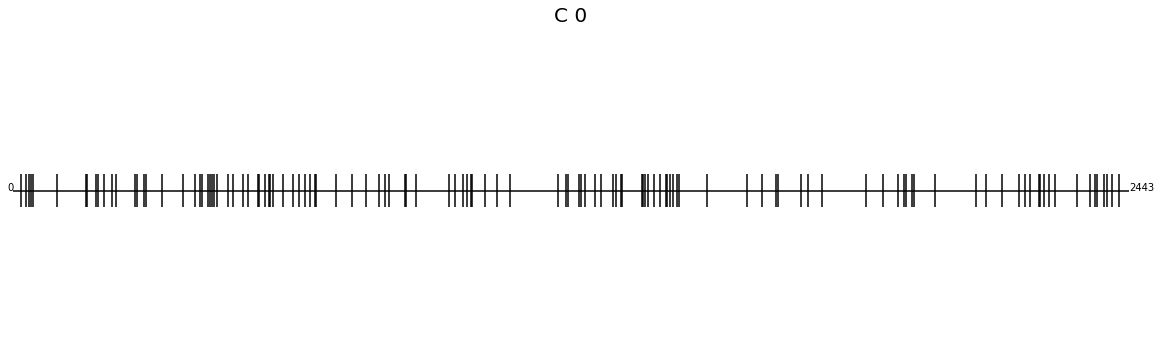

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,X_test.shape[0])
ax.set_ylim(0,10)
ax.set_title('C 0', fontsize = 20)

# draw lines
xmin = 1
xmax = X_test.shape[0]
y = 5
height = 1

plt.hlines(y, xmin, xmax)
C0 = (y_test == 1)
for i in range(len(C0)):
  if C0.iloc[i] == True:
    # print(i)
    plt.vlines(i, y - height / 2., y + height / 2.)
plt.text(xmin - 0.1, y, '0', horizontalalignment='right')
plt.text(xmax + 0.1, y, X_test.shape[0], horizontalalignment='left')
plt.axis('off')
plt.show()

Confusion Matrix:
[[2320    2]
 [   3  118]]
Accuracy: 0.9979533360622186
Precision: 0.9833333333333333
Recall: 0.9752066115702479
TPR:  0.9752066115702479
FPR:  0.0008613264427217916
F1 Score: 0.979253112033195
Temporal Distance 24.016666666666666
Squared Temporal Distance 144.10027777777776
Weighted Sum 118.99666666666667
Weighted Detection Difference 90.99666666666667


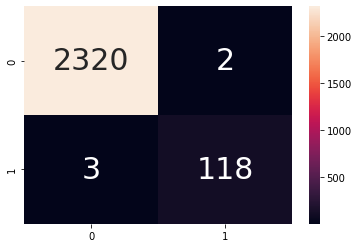

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))
print('Temporal Distance',temporal_distance(df,y_test,X_test,y_pred))
print('Squared Temporal Distance',squared_temporal_distance(df,y_test,X_test,y_pred))
print('Weighted Sum',weighted_sum(df,y_test,X_test,y_pred))
wdd, fa_array = weighted_detection_difference(df,y_test,X_test,y_pred)
print('Weighted Detection Difference',wdd)

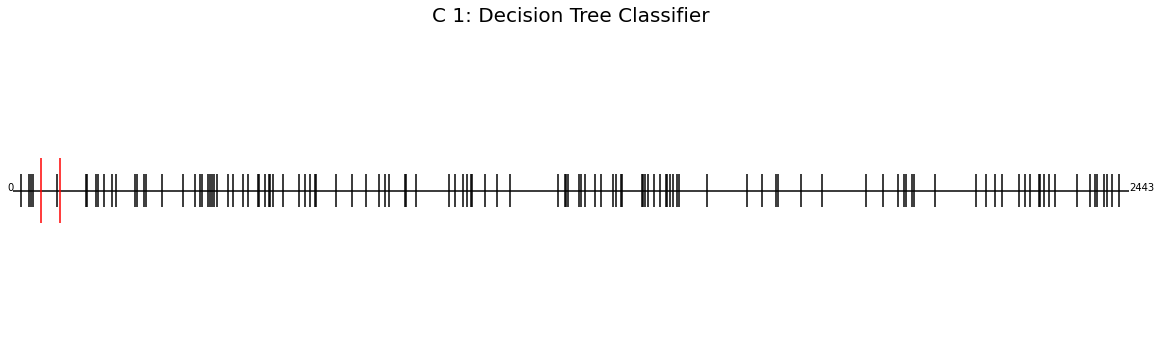

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,X_test.shape[0])
ax.set_ylim(0,10)
ax.set_title('C 1: Decision Tree Classifier', fontsize = 20)

# draw lines
xmin = 1
xmax = X_test.shape[0]
y = 5
height = 1

plt.hlines(y, xmin, xmax)
C0 = (y_pred == 1)
C0_X = X_test[C0]
C0_ind = C0_X.index
for i in range(len(C0)):
  if C0[i] == True:
    # print(i)
    plt.vlines(i, y - height / 2., y + height / 2.)

for i in range(len(fa_array)):
    ind_ = np.where(C0_ind == fa_array[i])
    # print(ind_)
    plt.vlines(ind_, y - height, y + height ,color = 'r')

plt.text(xmin - 0.1, y, '0', horizontalalignment='right')
plt.text(xmax + 0.1, y, X_test.shape[0], horizontalalignment='left')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Confusion Matrix:
[[2321    1]
 [   4  117]]
Accuracy: 0.9979533360622186
Precision: 0.9915254237288136
Recall: 0.9669421487603306
TPR:  0.9669421487603306
FPR:  0.0004306632213608958
F1 Score: 0.9790794979079498
Temporal Distance 202.98333333333332
Squared Temporal Distance 27998.83361111111
Weighted Sum 119.8
Weighted Detection Difference 114.81666666666666


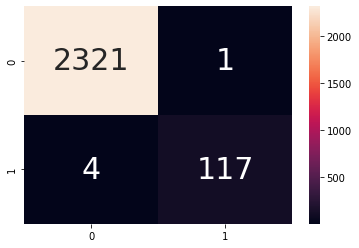

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))
print('Temporal Distance',temporal_distance(df,y_test,X_test,y_pred))
print('Squared Temporal Distance',squared_temporal_distance(df,y_test,X_test,y_pred))
print('Weighted Sum',weighted_sum(df,y_test,X_test,y_pred))
wdd, fa_array = weighted_detection_difference(df,y_test,X_test,y_pred)
print('Weighted Detection Difference',wdd)

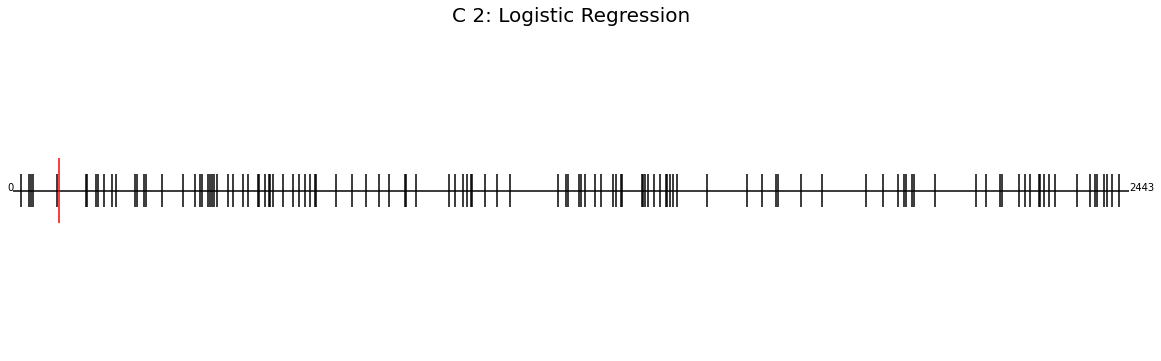

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,X_test.shape[0])
ax.set_ylim(0,10)
ax.set_title('C 2: Logistic Regression', fontsize = 20)

# draw lines
xmin = 1
xmax = X_test.shape[0]
y = 5
height = 1

plt.hlines(y, xmin, xmax)
C0 = (y_pred == 1)
C0_X = X_test[C0]
C0_ind = C0_X.index
for i in range(len(C0)):
  if C0[i] == True:
    # print(i)
    plt.vlines(i, y - height / 2., y + height / 2.)

for i in range(len(fa_array)):
    ind_ = np.where(C0_ind == fa_array[i])
    # print(ind_)
    plt.vlines(ind_, y - height, y + height ,color = 'r')

plt.text(xmin - 0.1, y, '0', horizontalalignment='right')
plt.text(xmax + 0.1, y, X_test.shape[0], horizontalalignment='left')
plt.axis('off')
plt.show()

In [ ]:
rows = X_test.index.values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = ['Temperature', 'Humidity', 'Light',	'CO2',	'HumidityRatio']
X_test.index = rows

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


<class 'numpy.ndarray'>
Confusion Matrix:
[[2321    1]
 [   6  115]]
Accuracy: 0.997134670487106
Precision: 0.9913793103448276
Recall: 0.9504132231404959
TPR:  0.9504132231404959
FPR:  0.0004306632213608958
F1 Score: 0.9704641350210972
Temporal Distance 22466.0
Squared Temporal Distance 126076022.63388889
Weighted Sum 117.03443669245324
Weighted Detection Difference 112.0511033591199


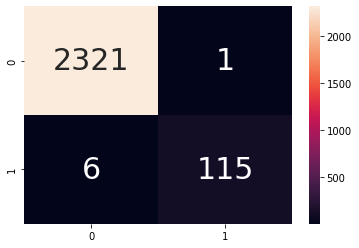

In [ ]:
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)
print(type(y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))
print('Temporal Distance',temporal_distance(df,y_test,X_test,y_pred))
print('Squared Temporal Distance',squared_temporal_distance(df,y_test,X_test,y_pred))
print('Weighted Sum',weighted_sum(df,y_test,X_test,y_pred))
wdd, fa_array = weighted_detection_difference(df,y_test,X_test,y_pred)
print('Weighted Detection Difference',wdd)

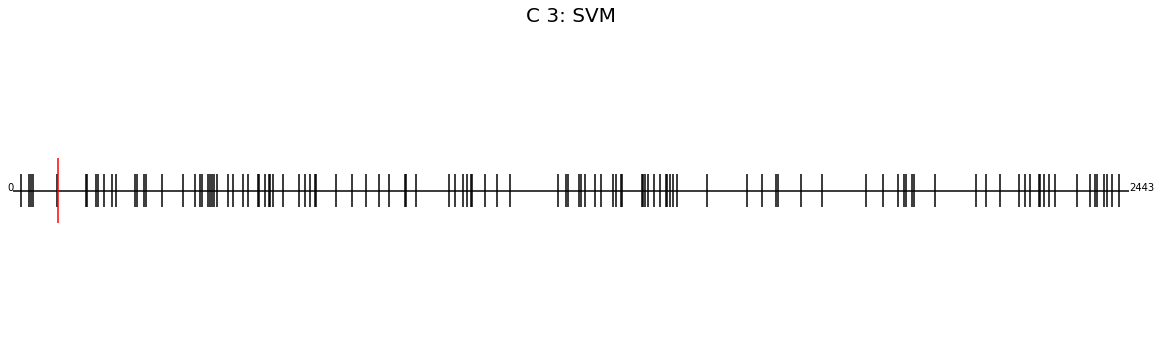

In [ ]:
fig = plt.figure(figsize = (20,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,X_test.shape[0])
ax.set_ylim(0,10)
ax.set_title('C 3: SVM', fontsize = 20)

# draw lines
xmin = 1
xmax = X_test.shape[0]
y = 5
height = 1

plt.hlines(y, xmin, xmax)
C0 = (y_pred == 1)
C0_X = X_test[C0]
C0_ind = C0_X.index
for i in range(len(C0)):
  if C0[i] == True:
    # print(i)
    plt.vlines(i, y - height / 2., y + height / 2.)

for i in range(len(fa_array)):
    ind_ = np.where(C0_ind == fa_array[i])
    # print(ind_)
    plt.vlines(ind_, y - height, y + height ,color = 'r')

plt.text(xmin - 0.1, y, '0', horizontalalignment='right')
plt.text(xmax + 0.1, y, X_test.shape[0], horizontalalignment='left')
plt.axis('off')
plt.show()

Sensor
---------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Modified_Datasets/IQROutlier_Classification/sensor.csv")
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,outlier
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0


In [ ]:
del df['Unnamed: 0']
del df['timestamp']
df = df.drop_duplicates()
del df['sensor_15']
df

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,outlier
0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0
2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0
3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0
4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0
5,2.453588,47.09201,53.168400,46.397568,637.615700,78.18568,13.41146,16.16753,15.89265,15.16204,...,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,0
220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,0
220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,0
220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,15.11863,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,0


In [ ]:
cols = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51']
val = df['sensor_50'][220319]
for s in cols:
  temp = df[s].copy()
  temp = temp.replace(val, 0)
  median = temp.median()
  df[s] = df[s].replace(val,median)

In [ ]:
for s in df.columns:
  print(s)
  print(df[s].isnull().sum())
  print('----------------')

sensor_00
0
----------------
sensor_01
0
----------------
sensor_02
0
----------------
sensor_03
0
----------------
sensor_04
0
----------------
sensor_05
0
----------------
sensor_06
0
----------------
sensor_07
0
----------------
sensor_08
0
----------------
sensor_09
0
----------------
sensor_10
0
----------------
sensor_11
0
----------------
sensor_12
0
----------------
sensor_13
0
----------------
sensor_14
0
----------------
sensor_16
0
----------------
sensor_17
0
----------------
sensor_18
0
----------------
sensor_19
0
----------------
sensor_20
0
----------------
sensor_21
0
----------------
sensor_22
0
----------------
sensor_23
0
----------------
sensor_24
0
----------------
sensor_25
0
----------------
sensor_26
0
----------------
sensor_27
0
----------------
sensor_28
0
----------------
sensor_29
0
----------------
sensor_30
0
----------------
sensor_31
0
----------------
sensor_32
0
----------------
sensor_33
0
----------------
sensor_34
0
----------------
sensor_35
0
--

In [ ]:
X_train, X_test = train_test_split(df, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[53370   108]
 [  134 11621]]
Accuracy: 0.9962902212070578
Precision: 0.9907920538835365
Recall: 0.9886005954912803
TPR:  0.9886005954912803
FPR:  0.002019522046449007
F1 Score: 0.9896951115653211


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[53204   274]
 [  470 11285]]
Accuracy: 0.9885947296613677
Precision: 0.9762955272947487
Recall: 0.9600170140365801
TPR:  0.9600170140365801
FPR:  0.005123602228953962
F1 Score: 0.9680878442137771


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[53102   376]
 [  488 11267]]
Accuracy: 0.9867551699293302
Precision: 0.967705917718801
Recall: 0.9584857507443642
TPR:  0.9584857507443642
FPR:  0.007030928606155802
F1 Score: 0.9630737669886316


Before and After Removal of Outliers
-------------------------------------------

Occupancy
--------------

In [ ]:
df_after = pd.read_csv("drive/MyDrive/Modified_Datasets/IQRAfterRemovingOutliers/occupancy.csv")
df_before = pd.read_csv('drive/MyDrive/Datasets/occupancy_train.txt')

In [ ]:
del df_after['date']
del df_before['date']
df_before = df_before.astype(float)
df_after = df_after.astype(float)

In [ ]:
X = df_before.drop('Occupancy',1)
y = df_before['Occupancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
clf_before=RandomForestClassifier(n_estimators=100,random_state=20)
clf_before.fit(X_train,y_train)
y_pred=clf_before.predict(X)

print("Confusion Matrix:")
print(confusion_matrix(y,y_pred))
print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision Weighted:",metrics.precision_score(y, y_pred, average='weighted'))
print("Recall Weighted:",metrics.recall_score(y, y_pred, average='weighted'))
print("F1 Score Weighted:",metrics.f1_score(y, y_pred, average='weighted'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[6408    6]
 [   3 1726]]
Accuracy: 0.9988947562323468
Precision Weighted: 0.9988958600973284
Recall Weighted: 0.9988947562323468
F1 Score Weighted: 0.998895105977549


In [ ]:
X_after = df_after.drop('Occupancy',1)
y_after = df_after['Occupancy']
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(X_after, y_after, test_size=0.3,random_state=5)
clf_after=RandomForestClassifier(n_estimators=100,random_state=20)
clf_after.fit(X_train_after,y_train_after)
y_pred_after=clf_after.predict(X_after)

print("Confusion Matrix:")
print(confusion_matrix(y_after,y_pred_after))
print("Accuracy:",metrics.accuracy_score(y_after, y_pred_after))
print("Precision Weighted:",metrics.precision_score(y_after, y_pred_after, average='weighted'))
print("Recall Weighted:",metrics.recall_score(y_after, y_pred_after, average='weighted'))
print("F1 Score Weighted:",metrics.f1_score(y_after, y_pred_after, average='weighted'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[6394    1]
 [   4 1331]]
Accuracy: 0.999353169469599
Precision Weighted: 0.9993531207417683
Recall Weighted: 0.999353169469599
F1 Score Weighted: 0.999352881514829


Sensor
--------------

In [ ]:
df_after = pd.read_csv("drive/MyDrive/Modified_Datasets/IQRAfterRemovingOutliers/sensor.csv")
df_before = pd.read_csv('drive/MyDrive/Datasets/sensor.csv')

In [ ]:
df_before.machine_status.unique()

In [ ]:
del df_before['Unnamed: 0']
del df_before['timestamp']
df_before = df_before.drop_duplicates()
del df_before['sensor_15']
del df_after['Unnamed: 0']
del df_after['timestamp']
df_after = df_after.drop_duplicates()
del df_after['sensor_15']

In [ ]:
cols = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51']
val = df_before['sensor_50'][220319]
for s in cols:
  temp = df_before[s].copy()
  temp = temp.replace(val, 0)
  median = temp.median()
  df_before[s] = df_before[s].replace(val,median)

for s in cols:
  temp = df_after[s].copy()
  temp = temp.replace(val, 0)
  median = temp.median()
  df_after[s] = df_after[s].replace(val,median)

In [ ]:
str_ar= ['machine_status']
df_before = MapFunc(df_before, str_ar)
df_after = MapFunc(df_after, str_ar)
df_before = df_before.astype(float)
df_after = df_after.astype(float)

In [ ]:
X = df_before.drop('machine_status',1)
y = df_before['machine_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=5)
clf_before=RandomForestClassifier(n_estimators=100,random_state=20)
clf_before.fit(X_train,y_train)
y_pred=clf_before.predict(X)

print("Confusion Matrix:")
print(confusion_matrix(y,y_pred))
print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision Weighted:",metrics.precision_score(y, y_pred, average='weighted'))
print("Recall Weighted:",metrics.recall_score(y, y_pred, average='weighted'))
print("F1 Score Weighted:",metrics.f1_score(y, y_pred, average='weighted'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[203169      0      0]
 [     0      6      1]
 [     4      1  14263]]
Accuracy: 0.9999724066886186
Precision Weighted: 0.9999724057611356
Recall Weighted: 0.9999724066886186
F1 Score Weighted: 0.9999724048449598


In [ ]:
X_after = df_after.drop('machine_status',1)
y_after = df_after['machine_status']
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(X_after, y_after, test_size=0.3,random_state=5)
clf_after=RandomForestClassifier(n_estimators=100,random_state=20)
clf_after.fit(X_train_after,y_train_after)
y_pred_after=clf_after.predict(X_after)

print("Confusion Matrix:")
print(confusion_matrix(y_after,y_pred_after))
print("Accuracy:",metrics.accuracy_score(y_after, y_pred_after))
print("Precision Weighted:",metrics.precision_score(y_after, y_pred_after, average='weighted'))
print("Recall Weighted:",metrics.recall_score(y_after, y_pred_after, average='weighted'))
print("F1 Score Weighted:",metrics.f1_score(y_after, y_pred_after, average='weighted'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[177029      0      0]
 [     0      4      0]
 [     3      1    934]]
Accuracy: 0.9999775244281371
Precision Weighted: 0.999978648492385
Recall Weighted: 0.9999775244281371
F1 Score Weighted: 0.9999778126479086
